In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from src.data_reading import parse_galaxy_data
from src.data_treatment_tools import add_radian_columns, new_CoM_procedure 
import matplotlib as mpl

In [2]:
mpl.rcParams['font.size'] = 12  # Taille générale
mpl.rcParams['axes.titlesize'] = 16  # Taille des titres des graphiques
mpl.rcParams['axes.labelsize'] = 14  # Taille des labels des axes
mpl.rcParams['xtick.labelsize'] = 12  # Taille des étiquettes de l'axe x
mpl.rcParams['ytick.labelsize'] = 12  # Taille des étiquettes de l'axe y
mpl.rcParams['legend.fontsize'] = 12  # Taille de la légende
mpl.rcParams['figure.titlesize'] = 18  # Taille du titre de la figure

In [ ]:
file_path = 'data/new_data.csv'
galaxy_df = pd.read_csv(file_path)
add_radian_columns(galaxy_df)

In [4]:
galaxy1="NGC5128_CenA"
galaxy2="NGC5236_M83"
r=0.76
CoM_Name="CoM_CenA_M83_0.76"
row_name=CoM_Name
new_CoM_procedure(galaxy_df,galaxy1,galaxy2,r,row_name=CoM_Name,grid_incertainty=True)
print(galaxy_df.columns)

CoM_CenA_M83_0.76
Index(['Name', 'PGC', 'RA', 'Dec', 'Dis', 'e_Dis_min', 'e_Dis_max', 'ref_dis',
       'V_h', 'e_V_h', 'ref_V_h', 'Source', 'Type', 'e_V_LG', 'RA_radians',
       'Dec_radians', 'cos_theta_CoM_CenA_M83_0.76',
       'angular_distance_CoM_CenA_M83_0.76', 'dis_center_CoM_CenA_M83_0.76',
       'e_dis_center_min_CoM_CenA_M83_0.76',
       'e_dis_center_max_CoM_CenA_M83_0.76',
       'major_infall_velocity_CoM_CenA_M83_0.76',
       'e_major_infall_velocity_min_CoM_CenA_M83_0.76',
       'e_major_infall_velocity_max_CoM_CenA_M83_0.76',
       'minor_infall_velocity_CoM_CenA_M83_0.76',
       'e_minor_infall_velocity_min_CoM_CenA_M83_0.76',
       'e_minor_infall_velocity_max_CoM_CenA_M83_0.76'],
      dtype='object')


In [5]:
G = 4.3009e-9  

# Mass calculation

In [6]:
### cuts
velocity_max = 500
velocity_min = -500

distance_max = 1


### Virial Mass

In [7]:
def Viriel_Mass(df,velocity, galaxy_excluded,row_name="CoM_CenA_M83_0.76"):
    mask = (
    (~df['Name'].str.startswith('CoM_')) & 
    (~df['Name'].isin(galaxy_excluded))  &
    (df[velocity+"_"+row_name] >= velocity_min)  &
    (df[velocity+"_"+row_name] <= velocity_max)   &
    (df["dis_center_"+row_name]<= distance_max)
    )
    sigma_v=(df[mask][velocity+"_"+row_name] ** 2).mean()
    R_g=1/((1/df[mask]["dis_center_"+row_name]).mean())
    return (3/G)*sigma_v*R_g

In [8]:
M_minor= Viriel_Mass(galaxy_df,velocity="minor_infall_velocity",galaxy_excluded=[galaxy1,galaxy2])
M_major= Viriel_Mass(galaxy_df,velocity="major_infall_velocity",galaxy_excluded=[galaxy1,galaxy2])
print(f"The Virial Mass according to the minor infall model with a bound system of {distance_max} Mpc is: {M_minor:.2e} M_⊙")
print(f"The Virial Mass according to the major infall model with a bound system of {distance_max} Mpc is: {M_major:.2e} M_⊙")

The Virial Mass according to the minor infall model with a bound system of 1 Mpc is: 1.77e+12 M_⊙
The Virial Mass according to the major infall model with a bound system of 1 Mpc is: 6.34e+12 M_⊙


### Projected Mass

In [9]:
def projected_mass(df,velocity, galaxy_excluded,row_name="CoM_CenA_M83_0.76",C=64/np.pi):
    mask = (
    (~df['Name'].str.startswith('CoM_')) & 
    (~df['Name'].isin(galaxy_excluded))  &
    (df[velocity+"_"+row_name] >= velocity_min)  &
    (df[velocity+"_"+row_name] <= velocity_max)   &
    (df["dis_center_"+row_name]<= distance_max)
    )
    mean=((df[mask][velocity+"_"+row_name] ** 2)*df[mask]["dis_center_"+row_name]).mean()
    return (C/G)*mean

In [10]:
M_major= projected_mass(galaxy_df,velocity="major_infall_velocity",galaxy_excluded=[galaxy1,galaxy2])
M_minor= projected_mass(galaxy_df,velocity="minor_infall_velocity",galaxy_excluded=[galaxy1,galaxy2])
print(f"The Projected Mass according to the minor infall model with a bound system of {distance_max} Mpc is: {M_minor:.2e} M_⊙")
print(f"The Projected Mass according to the major infall model with a bound system of {distance_max} Mpc is: {M_major:.2e} M_⊙")

The Projected Mass according to the minor infall model with a bound system of 1 Mpc is: 2.17e+13 M_⊙
The Projected Mass according to the major infall model with a bound system of 1 Mpc is: 5.60e+13 M_⊙


# Frequency analysis

In [11]:
def sample_asymmetric_gaussian(mean, sigma_minus, sigma_plus, size=1):
    u = np.random.rand(size)
    sigma = np.where(u < sigma_minus / (sigma_minus + sigma_plus), sigma_minus, sigma_plus)
    direction = np.where(u < sigma_minus / (sigma_minus + sigma_plus), -1, 1)
    return mean + direction * np.abs(np.random.normal(0, sigma, size))

def virial_mass_monte_carlo(df, velocity, galaxy_excluded, row_name="CoM_CenA_M83_0.76",
                             velocity_min=-np.inf, velocity_max=np.inf, distance_max=np.inf,
                             N_samples=1000):

    
    # Apply the same filtering mask
    vel_col = velocity + "_" + row_name
    dis_col = "dis_center_" + row_name
    e_min_vel_col = "e_" + velocity+ "_min_"+row_name
    e_min_dis_col = "e_" + "dis_center_" + "min_"+row_name
    e_max_vel_col = "e_" + velocity+ "_max_"+row_name
    e_max_dis_col = "e_" + "dis_center_" + "max_"+row_name

    mask = (
        (~df['Name'].str.startswith('CoM_')) &
        (~df['Name'].isin(galaxy_excluded)) &
        (df[vel_col] >= velocity_min) &
        (df[vel_col] <= velocity_max) &
        (df[dis_col] <= distance_max) &
        (df[e_max_dis_col].notna()) &
        (df[e_max_vel_col].notna()) &
        (df[e_min_dis_col].notna()) &
        (df[e_min_vel_col].notna())
    )

    df_filtered = df[mask].copy()
    virial_masses = []
    for _ in range(N_samples):
        # Randomly sample velocity and distance with Gaussian noise
        sampled_vel = sample_asymmetric_gaussian(
            df_filtered[vel_col].values,
            df_filtered[e_min_vel_col].values,
            df_filtered[e_max_vel_col].values,
            size=len(df_filtered)
        )
        
        sampled_dis = sample_asymmetric_gaussian(
            df_filtered[dis_col].values,
            df_filtered[e_min_dis_col].values,
            df_filtered[e_max_dis_col].values,
            size=len(df_filtered)
        )
        # Avoid division by zero or negative distances
        sampled_dis = np.clip(sampled_dis, 1e-3, None)
        print(sampled_dis)
        # Compute sigma_v and R_g for this sample

        sigma_v = (sampled_vel ** 2).mean()
        R_g = 1 / ((1 / sampled_dis).mean())
        M_vir = (3 / G) * sigma_v * R_g
        virial_masses.append(M_vir)

    # Plot histogram

    # Convert to NumPy array and drop values outside the range
    virial_masses = np.array(virial_masses)
    virial_masses = virial_masses[(virial_masses > 0) & (virial_masses <= 2e12)]
    median = np.median(virial_masses)
    sigma = np.std(virial_masses)
    
    print(f"Median Virial Mass: {median:.2e} Msun")
    print(f"Standard Deviation (σ): {sigma:.2e} Msun")
    # Define bin edges linearly spaced from 0 to 1e13
    bins = np.linspace(0, 2e12, 100)

    # Plot the histogram
    plt.figure(figsize=(8, 5))
    plt.hist(virial_masses, bins=bins, color='steelblue', edgecolor='k')
    plt.xlabel('Virial Mass [Msun]')
    plt.ylabel('Frequency')
    plt.xlim(0, 2e12)  # Optional: narrower x-axis for better visibility
    plt.title('Monte Carlo Simulation of Virial Mass')
    plt.grid(True)
    plt.show()

    return virial_masses


[ 7.35044478 11.01347271  8.25453557  9.96337488  7.00546661  5.20066505
  9.20245679  3.37548227  0.21492094  1.89868861  6.03222607  9.38366902
  9.81460094  3.67650785 10.55802458  3.29900298  1.36331917  3.00175989
 11.4151333   0.7736285   0.97621503  0.34476404  0.3667314   0.28506442
  0.30874552  0.3894103   2.94725793  1.25253299  1.97540628  4.61139321
  3.04531373  1.22309109  0.29711243  0.19434434  0.62173899  0.57708198
 11.72532924  4.82703482  2.10983345  2.29067241  1.94410037  1.68685025
  0.85117629  0.97406353  0.84521349  5.81536937  2.23708877  1.06623481
  8.41978813  8.24414861  7.89338395  8.02533768  8.10845278  6.3290301
  3.96074138  0.66056855  1.86540563  1.89182385  1.03624947  0.36581149
  3.59526855  6.92257277  9.10186251 10.68115776  7.57223116  5.26240793
 12.26644693  0.44543809  0.20435522  0.26092432  0.11015241  0.40992598
  0.41204736  0.38289462  0.27087936  0.90044027  0.68753063 11.38455911
  7.14871491  4.05855819  3.11959083  7.04181991  8.

C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Adrian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid va

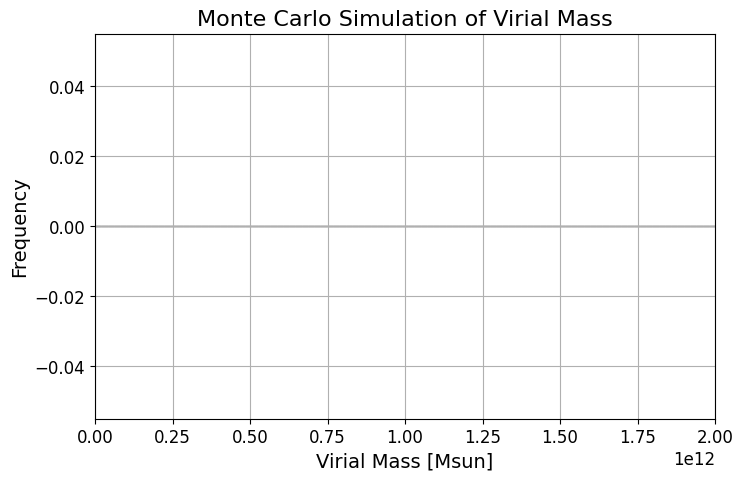

In [12]:
masses = virial_mass_monte_carlo(galaxy_df, velocity="minor_infall_velocity", galaxy_excluded=[galaxy1,galaxy2])

In [13]:
masses = virial_mass_monte_carlo(galaxy_df, velocity="major_infall_velocity_bis", galaxy_excluded=[galaxy1,galaxy2])

KeyError: 'major_infall_velocity_bis_CoM_CenA_M83_0.76'